In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
%matplotlib inline

In [2]:
file_path = './全部数据/附件2-行业日负荷数据.csv'
data = pd.read_csv(file_path, parse_dates=['数据时间'], index_col=[1])
data

,行业类型,有功功率最大值（kw）,有功功率最小值（kw）
数据时间,,,
2019-01-01,大工业用电,117888.3300,51526.5690
2019-01-02,大工业用电,126843.7914,63638.4294
2019-01-03,大工业用电,130286.1294,102048.2754
2019-01-04,大工业用电,133018.6344,104466.0762
2019-01-05,大工业用电,133504.4784,99507.3528
...,...,...,...
2021-08-27,商业,104728.8762,19815.7638
2021-08-28,商业,93855.1368,20820.2490
2021-08-29,商业,84127.1658,21679.5828


In [3]:
data1 = data[data['行业类型'] == '大工业用电']
data2 = data[data['行业类型'] == '非普工业']
data3 = data[data['行业类型'] == '普通工业']
data4 = data[data['行业类型'] == '商业']

In [7]:
# 用原数据减去滑动平均数据的方法，求出波动图，再通过箱型图的方法将异常数据赋值为np.NaN
# prophet会根据插值的方法自动填充np.NaN值
def drop_outlier(data1, column, window=15):
    data_smooth = data1.iloc[:,column].rolling(window, center=True).mean()
    
    # 用滑动窗口给data_smooth数据两边各有window//2个的np.NaN值填充
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data1.iloc[j,column]
        data_smooth[i] = sum / (i+1)
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data1.iloc[len(data_smooth) - j - 1, column]
        data_smooth[len(data_smooth) - i - 1] = sum / (i+1)
    
    data_sub = data1.iloc[:,column] - data_smooth
    
    q1 = data_sub.quantile(0.25)
    q3 = data_sub.quantile(0.75)
    
    # 分别为箱线图的上界和下界
    upper_whisker = q3 + 1.5*(q3-q1)
    lower_whisker = q1 - 1.5*(q3-q1)

    rule = (lower_whisker > data_sub) | (upper_whisker < data_sub)
    
    data_drop_outlier = data1.copy()
    data_drop_outlier.loc[rule, data_drop_outlier.columns[column]] = np.NaN
    
    return data_drop_outlier

In [80]:
def FB(data1, column):
    df = pd.DataFrame({
        'ds': pd.Series(data1.iloc[:,column].index),
        'y': pd.Series(data1.iloc[:,column].values)
        })
    df['cap'] = data1.iloc[:,column].max()
    df['floor'] = data1.iloc[:,column].min()
    
    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=False,
        yearly_seasonality=True, #年周期性
        weekly_seasonality=True, #周周期
        growth="linear",
        interval_width=0.8 #置信区间宽度，有多大概率落在浅蓝色线里

    )

    m.add_country_holidays(country_name='CN')#中国所有的节假日    

    m.fit(df)

    future = m.make_future_dataframe(periods=91)
    future['cap'] = data1.iloc[:,column].max()
    future['floor'] = data1.iloc[:,column].min()

    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)
    
    dic = {data1.columns[0]:data1.values[-91:,0], data1.columns[column]:forecast.yhat.values[-91:]}
    pred = pd.DataFrame(dic, index=pd.date_range('2021-09', periods=91))
    pred.index.name = '数据时间'
    return pred

In [81]:
def predict(data1, column):
    data1_copy = drop_outlier(data1, column)
    yhat = FB(data1_copy, column)
    return yhat

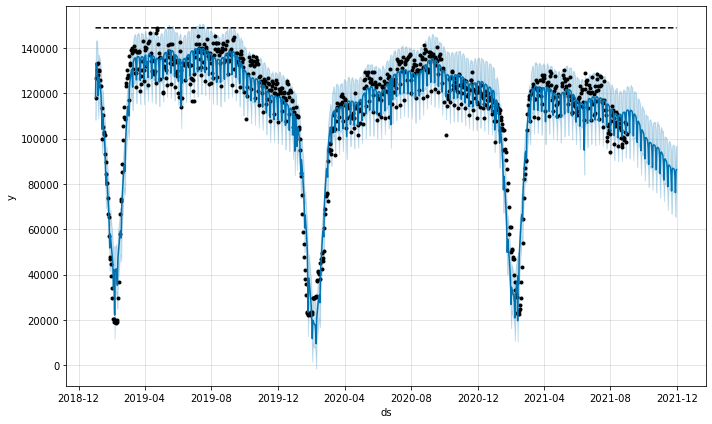

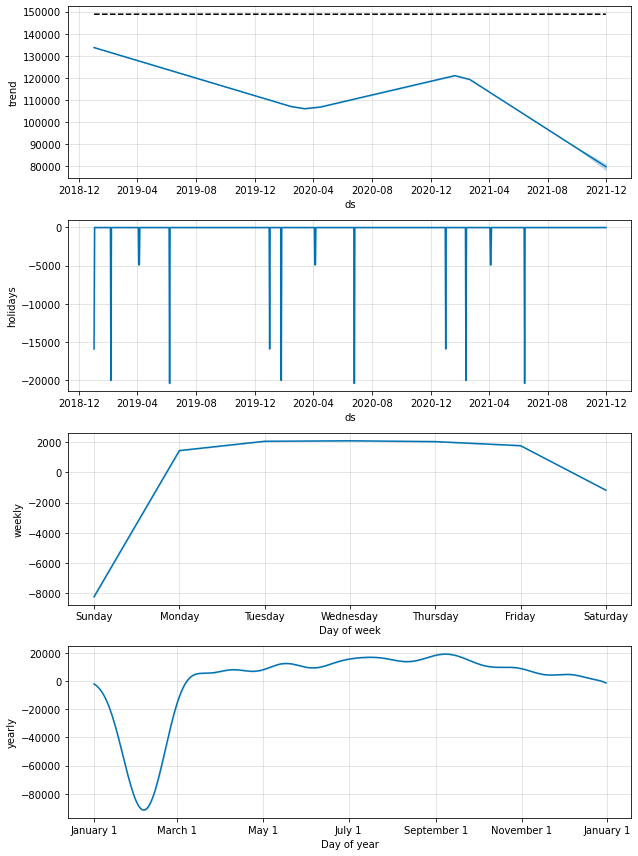

In [86]:
# 大工业最大值
data11_pred = predict(data1, 1)

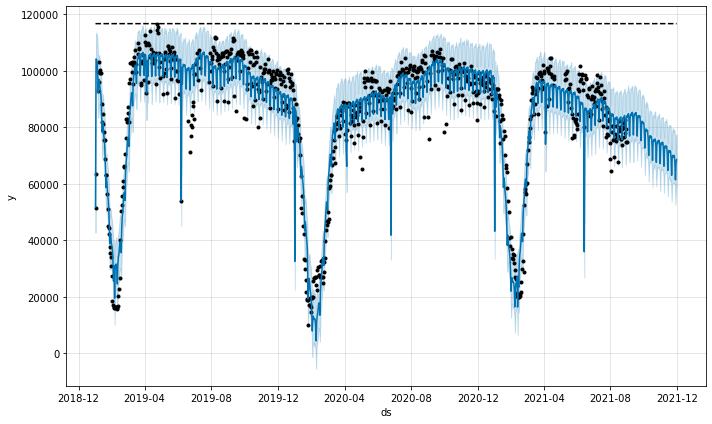

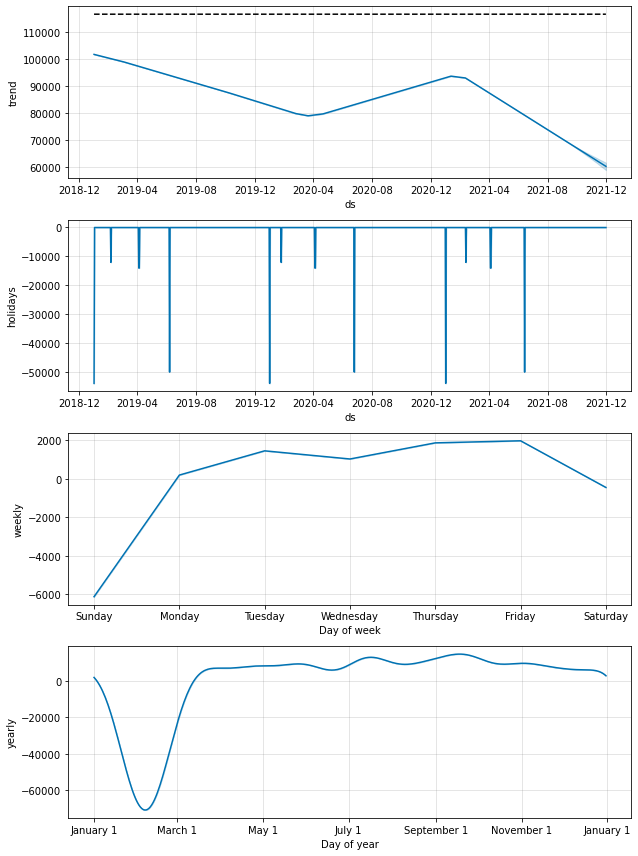

In [88]:
# 大工业最小值
data12_pred = predict(data1, 2)

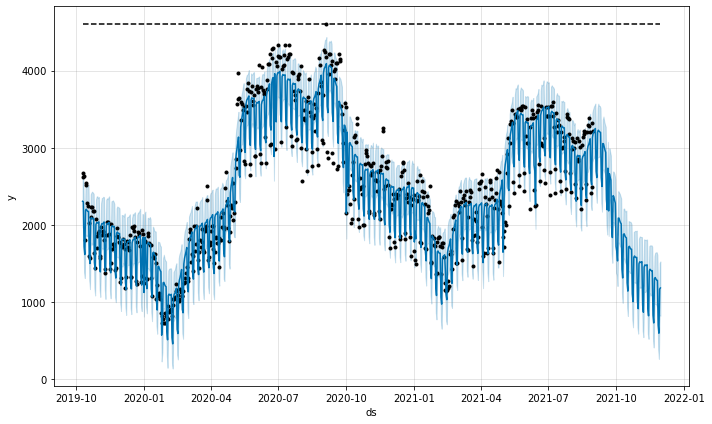

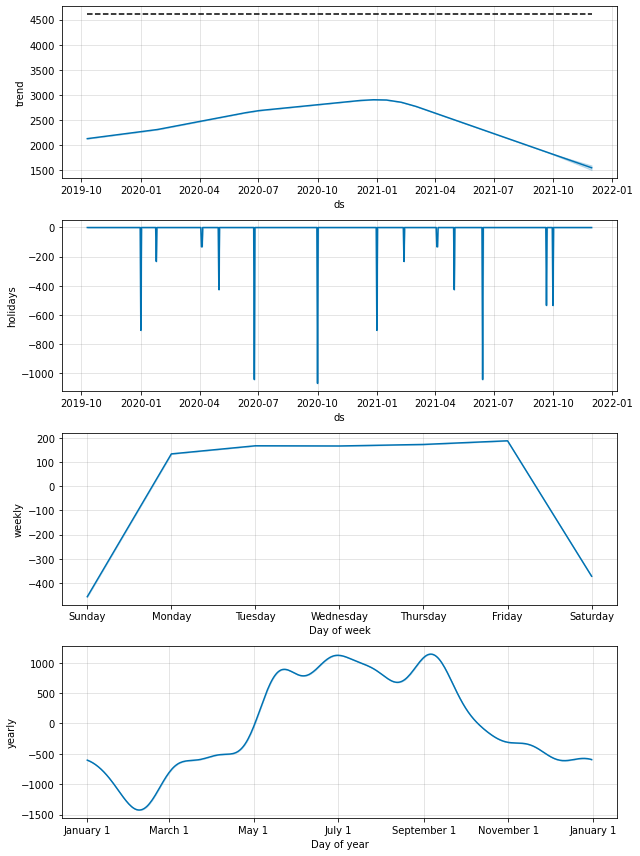

In [87]:
# 非普工业最大值
data21_pred = predict(data2, 1)

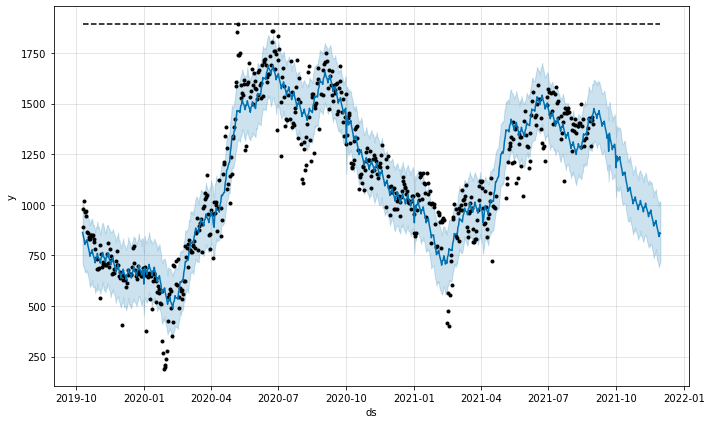

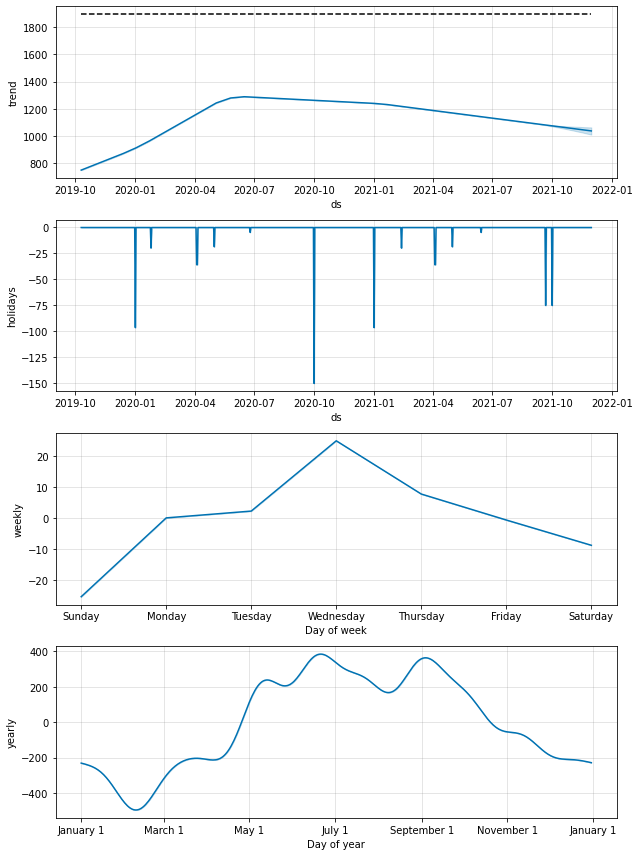

In [89]:
# 非普工业最小值
data22_pred = predict(data2, 2)

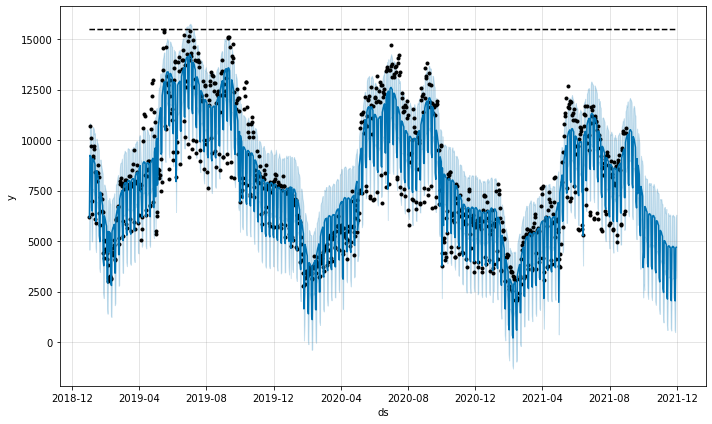

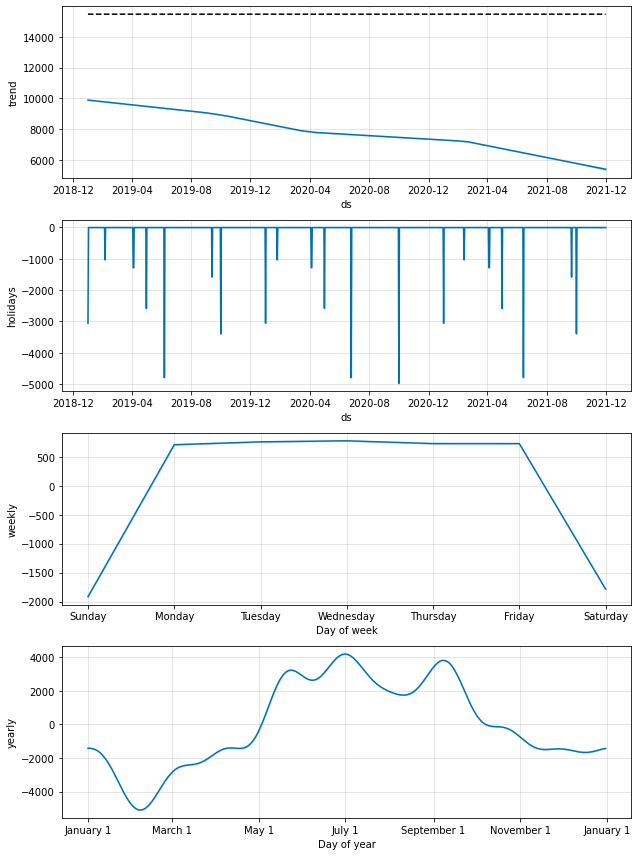

In [90]:
# 普通工业最大值
data31_pred = predict(data3, 1)

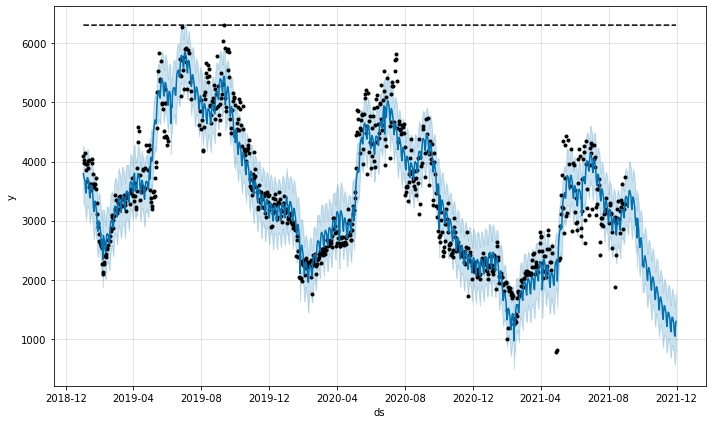

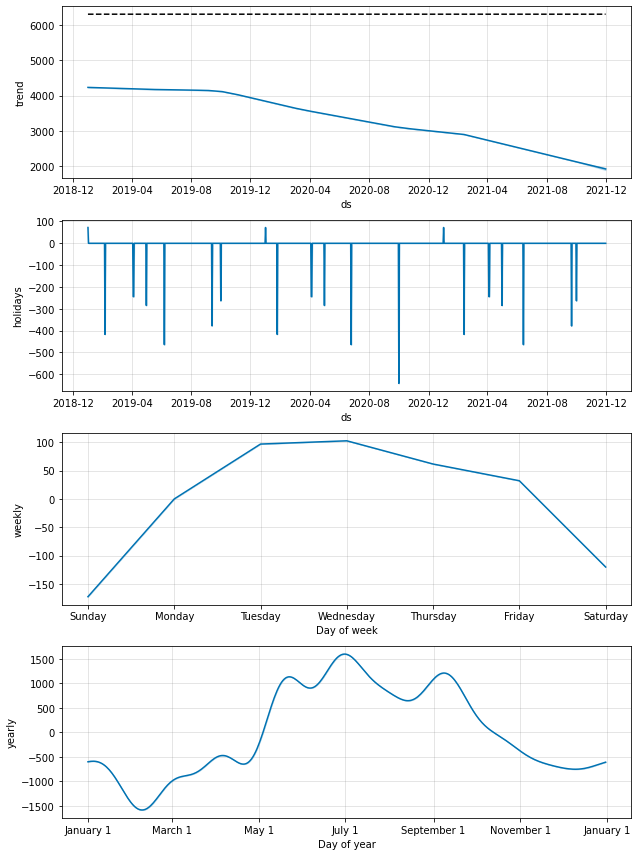

In [91]:
# 普通工业最小值
data32_pred = predict(data3, 2)

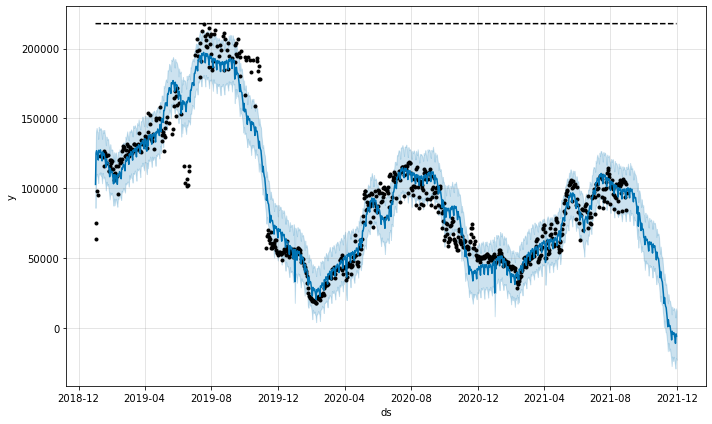

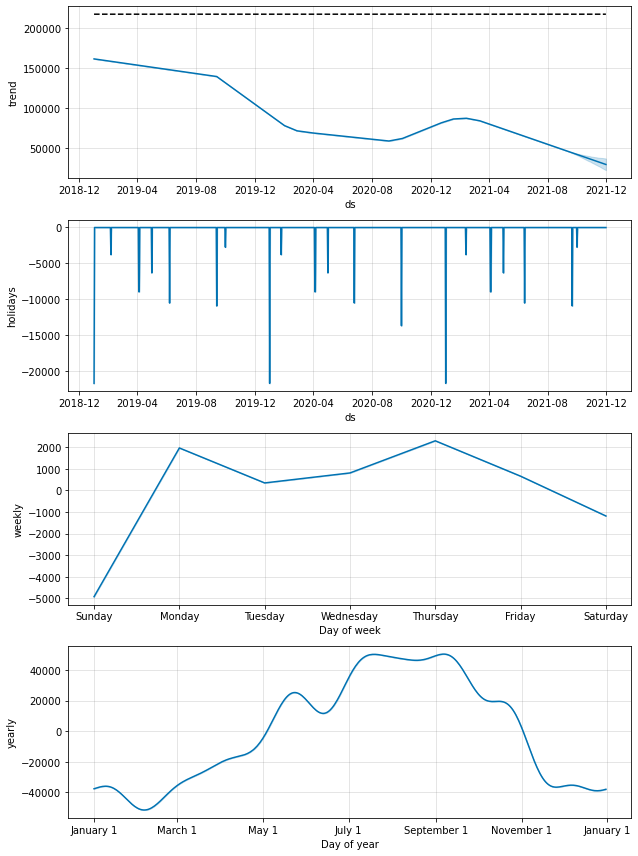

In [92]:
# 商业最大值，预测值出现负值，可见预测效果出现异常，说明数据有问题，需要手动筛选
data41_pred = predict(data4, 1)

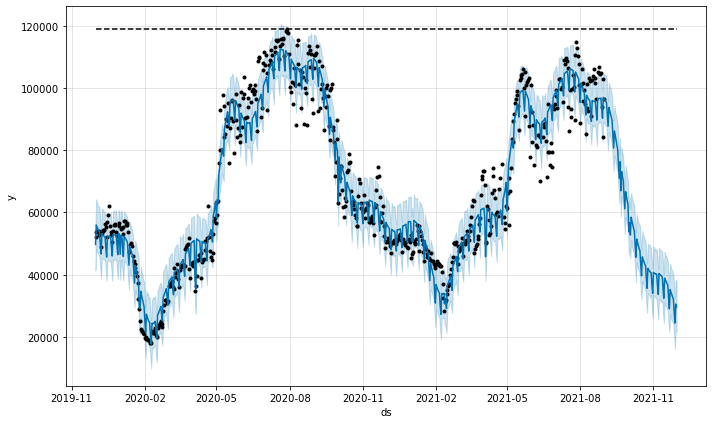

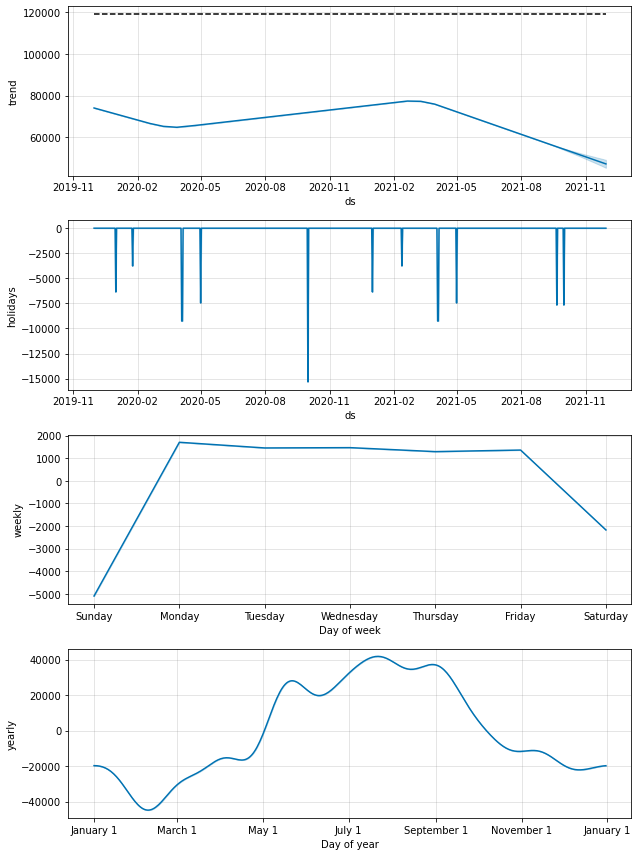

In [93]:
# 商业最大值，将2019年12月以前的数据剔除出去，预测结果正常
data41_pred = predict(data4['2019-12':], 1)

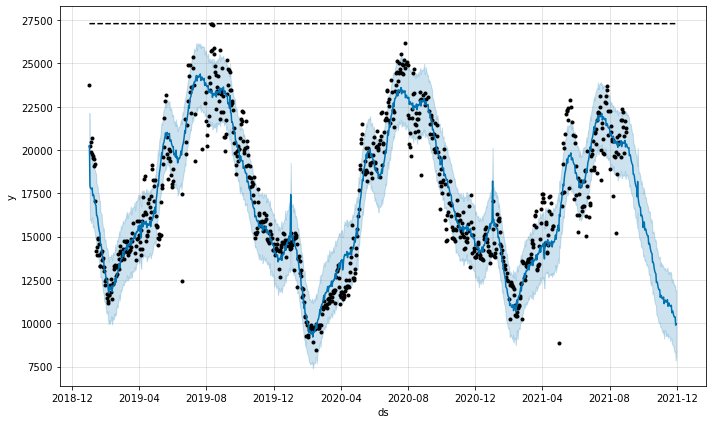

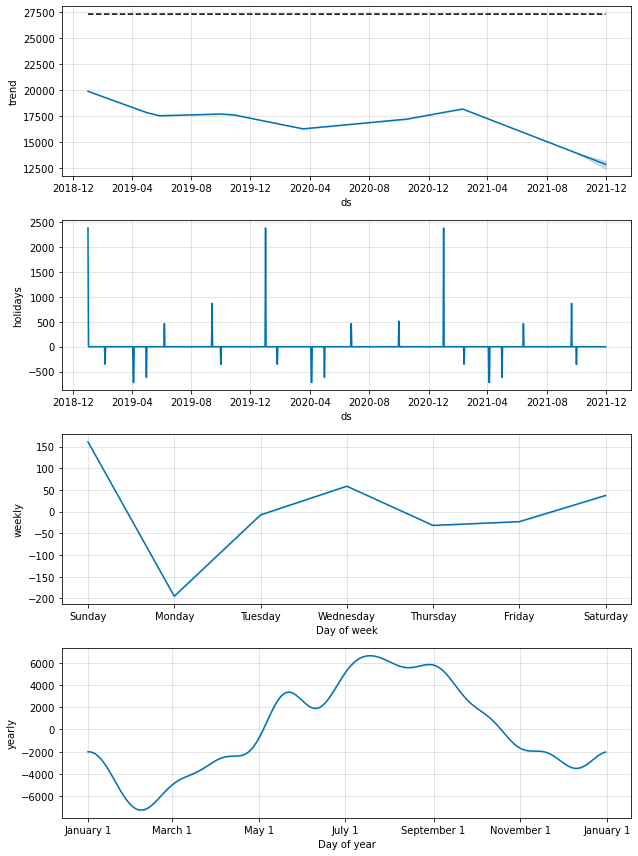

In [94]:
# 商业最小值
data42_pred = predict(data4, 2)

In [118]:
data1_pred = pd.concat([data11_pred, data12_pred], axis=1).iloc[:,[0,1,3]]
data2_pred = pd.concat([data21_pred, data22_pred], axis=1).iloc[:,[0,1,3]]
data3_pred = pd.concat([data31_pred, data32_pred], axis=1).iloc[:,[0,1,3]]
data4_pred = pd.concat([data41_pred, data42_pred], axis=1).iloc[:,[0,1,3]]

In [120]:
data_pred = pd.concat([data1_pred, data2_pred, data3_pred, data4_pred])

In [121]:
data_pred.to_csv('各行业未来三个月日负荷最大值最小值预测.csv', encoding='utf_8_sig')